$$\newcommand{\E}{E}$$
$$\newcommand{\rbar}{\bar{r}}$$
$$\newcommand{\rvec}{\boldsymbol{r}}$$
$$\newcommand{\rvecbar}{\boldsymbol{\bar{r}}}$$

$$\newcommand{\Ntime}{N}$$
$$\newcommand{\Nt}{N}$$

$$\newcommand{\rmat}{\boldsymbol{R}}$$

$$\newcommand{\riskmeasure}{\varrho}$$

$$\newcommand{\wt}{w}$$

$$\newcommand{\Nassets}{K}$$

$$\newcommand{\muvec}{\boldsymbol{\mu}}$$

$$\newcommand{\onevecNt}{\boldsymbol{1}_{\Ntime\times 1}}$$

$$\newcommand{\covest}{\hat{\boldsymbol{\Sigma}}}$$

$$\newcommand{\meanest}{\hat{\mu}}$$

$$\newcommand{\meanestvec}{\hat{\boldsymbol{\mu}}}$$

$$\newcommand{\covmat}{\boldsymbol{\Sigma}}$$

$$\newcommand{\rf}{r_f}$$

In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)

from sklearn.linear_model import LinearRegression
import sys
sys.path.insert(0,'../cmds')
from portfolio import *
from risk import *

In [2]:
LOADFILE = '../data/risk_etf_data.xlsx'
info = pd.read_excel(LOADFILE,sheet_name='descriptions').set_index('ticker')
rets = pd.read_excel(LOADFILE,sheet_name='total returns').set_index('Date')
prices = pd.read_excel(LOADFILE,sheet_name='prices').set_index('Date')

FREQ = 252

# Multivariable Risk

All the risk measures above are **univariate**.
* The measures above for a return $r$ depend only on functions of the distribution (sample) of $r$.

We will need to consider **multivariable measures**.
* As we will see, the risk for a portfolio will require these measures.

### Notation
Consider a return on asset $i$ and $j$, denoted as $r_i$ and $r_j$.
* Note that these superscripts are not exponents but rather identifiers.

## Covariance

The covariance is defined as

$$\sigma_{i,j} = \E\left[(r_{i,t}-\mu_i)(r_{j,t}-\mu_j)\right]$$

* A covariance of a variable with itself is the variance.

The sample estimate of the covariance is

$$\hat{\sigma}_{i,j} = \frac{1}{\Ntime}\sum_{t=1}^\Ntime\left(r_{i,t} - \meanest_i\right)\left(r_{j,t} - \meanest_j\right)$$

#### Covariance Matrix

For $\Nassets$ assets, it is easier to use matrix notation to write the coviariance $\sigma_{i,j}$ as the $i$ row and $j$ column of the $\Nassets\times \Nassets$ **covariance matrix**.
* Note that the diagonal of the matrix is the set of asset variances, $\sigma_{j,j}=\sigma^2_j$.

Let $\rmat$ denote the $\Ntime\times \Nassets$ matrix of sample returns.
* Each of $\Ntime$ rows is a sample observation (period of time).
* Each of $\Nassets$ columns is an asset return.

Perhaps somewhat confusingly, it is common to denote this covariance matrix using the capital Greek letter, $\Sigma$. This looks like a summation sign, but it denotes the $\Nassets\times \Nassets$ covariance:

$$\covmat = \E\left[(\rvec-\muvec)(\rvec-\muvec)'\right]$$

The sample estimator is the $\Nassets\times\Nassets$ matrix,
$$\covest = (\rmat-\meanestvec)(\rmat-\meanestvec)'\left(\frac{1}{\Ntime-\Nassets}\right)$$

where $\meanest$ denotes the $\Nassets\times 1$ vector of sample averages:

$$\meanestvec = \rmat'\onevecNt \left(\frac{1}{\Ntime}\right)$$

and where $\onevecNt$ denotes the $\Ntime\times 1$ vector of ones.

#### Technical Note: Properties of the Covariance Matrix
The covariance matrix is
* symmetric: $\Nassets(\Nassets+1)/2$ unique elements
* positive (semi) definite

Positive definite
* does **not** mean each element of the matrix, $\sigma_{i,j}$ is positive
* it means that any combination of the assets will have non-negative variance.

Mathematically, for any $\Nassets\times 1$ $w$, 
$$w'\covest w\ge 0$$

In [3]:
rets.cov().style.format('{:.4%}')

,SPY,VEA,UPRO,GLD,USO,CL1,FXE,BTC,HYG,IEF,TIP,SHV
SPY,0.0152%,0.0125%,0.0458%,0.0004%,0.0106%,0.0165%,0.0005%,0.0136%,0.0055%,-0.0014%,-0.0002%,-0.0000%
VEA,0.0125%,0.0130%,0.0378%,0.0012%,0.0101%,0.0146%,0.0014%,0.0136%,0.0049%,-0.0012%,0.0001%,-0.0000%
UPRO,0.0458%,0.0378%,0.1386%,0.0012%,0.0319%,0.0495%,0.0015%,0.0411%,0.0168%,-0.0043%,-0.0006%,-0.0001%
GLD,0.0004%,0.0012%,0.0012%,0.0073%,0.0014%,0.0014%,0.0014%,0.0039%,0.0006%,0.0011%,0.0012%,0.0000%
USO,0.0106%,0.0101%,0.0319%,0.0014%,0.0690%,0.1147%,-0.0003%,0.0083%,0.0044%,-0.0016%,0.0013%,-0.0001%
CL1,0.0165%,0.0146%,0.0495%,0.0014%,0.1147%,0.8984%,-0.0003%,0.0197%,0.0091%,-0.0022%,0.0020%,-0.0001%
FXE,0.0005%,0.0014%,0.0015%,0.0014%,-0.0003%,-0.0003%,0.0019%,0.0014%,0.0004%,0.0002%,0.0002%,0.0000%
BTC,0.0136%,0.0136%,0.0411%,0.0039%,0.0083%,0.0197%,0.0014%,0.2417%,0.0050%,-0.0005%,0.0010%,-0.0000%
HYG,0.0055%,0.0049%,0.0168%,0.0006%,0.0044%,0.0091%,0.0004%,0.0050%,0.0032%,-0.0002%,0.0002%,-0.0000%
IEF,-0.0014%,-0.0012%,-0.0043%,0.0011%,-0.0016%,-0.0022%,0.0002%,-0.0005%,-0.0002%,0.0014%,0.0009%,0.0000%


## Correlation

The scale of the covariance matrix makes it harder to interpret.

Consider the **correlation**, which rescales the covariance in a way that is much more useful for interpretation:
* between -1 and 1
* same sign as the covariance

$$\rho_{i,j} = \frac{\sigma_{i,j}}{\sigma_i\sigma_j}$$

Consider the matrix of correlations.
* will be positive semi-definite, as is the covariance matrix.

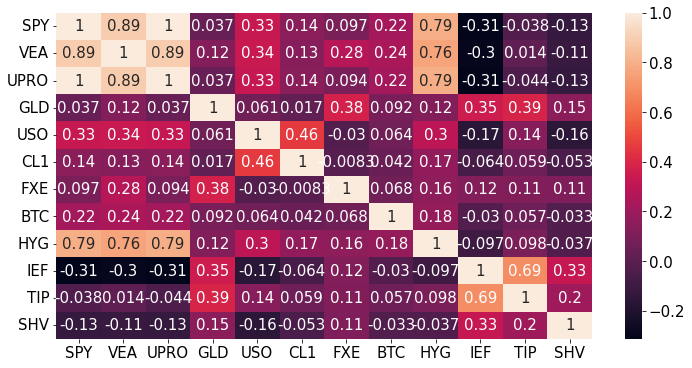

In [4]:
sns.heatmap(rets.corr(),annot=True);

## Beta

Consider a linear decomposition of $r_i$ on $r_j$:
$$r_{i,t} = \alpha + \beta r_{j,t} + \epsilon_t$$

The OLS sample estimator of $\beta$ is
$$\begin{bmatrix}\hat{\alpha}\\ \hat{\beta}\end{bmatrix} = (\rmat_j'\rmat_j)^{-1}\rmat_j'\rvec_i$$

where $\rmat_j$ denotes the $N\times 2$ matrix where the first column is a vector of ones and the second column is the vector of sample returns of $r_{j,t}$ for $1\le t\le \Ntime$.


### Scaled correlation
Equivalently, for a single-variable regression, the **beta is simply a scaled correlation**:

$$\beta = \frac{\sigma_i}{\sigma_j}\rho_{i,j}$$

The sample estimator is then the product of the sample estimates of these standard deviations and the correlation.

Thus, for bivariate measures, 
#### Covariance, correlation, and beta are just three ways of scaling the relationship

In [5]:
COMP = 'SPY'
birisk = pd.DataFrame(dtype=float, columns=['corr','cov','beta'], index=rets.columns)
birisk['corr'] = rets.corr()[COMP]
birisk['cov'] = rets.cov()[COMP]
for sec in rets.columns:
    birisk.loc[sec,'beta'] = LinearRegression().fit(rets[[COMP]],rets[[sec]]).coef_[0]

birisk.columns = [f'{COMP} {col}' for col in birisk.columns]
birisk.style.format({birisk.columns[0]:'{:.2%}',birisk.columns[1]:'{:.4%}',birisk.columns[2]:'{:.4f}'})

,SPY corr,SPY cov,SPY beta
SPY,100.00%,0.0152%,1.0000
VEA,89.10%,0.0125%,0.8248
UPRO,99.91%,0.0458%,3.0224
GLD,3.68%,0.0004%,0.0255
USO,32.93%,0.0106%,0.7025
CL1,14.17%,0.0165%,1.0914
FXE,9.73%,0.0005%,0.0343
BTC,22.41%,0.0136%,0.8951
HYG,79.06%,0.0055%,0.3654
IEF,-30.91%,-0.0014%,-0.0929


## Multivariate Beta

Beta as a rescaled correlation is helpful, but regression betas can be much more.

Consider a multivariate regression:

$$r_{i,t} = \alpha + \beta_j r_{j,t} +\beta_k r_{k,t} + \epsilon_t$$

The OLS sample estimator of $\beta$ is
$$\begin{bmatrix}\hat{\alpha}\\ \hat{\beta}_j\\ \hat{\beta}_k\end{bmatrix} = (\rmat'\rmat)^{-1}\rmat'\rvec_i$$

noting that here $\rmat$ denotes the matrix with columns of 
* ones, 
* $r_{j,t}$
* $r_{k,t}$

That is, each row is an observation, $t$, and each colmn is a variable, $(1, r_j, r_k)$.

In [6]:
COMPS = ['SPY','VEA']
betas = pd.DataFrame(dtype=float, columns=COMPS, index=rets.columns)
for sec in rets.columns:
    betas.loc[sec] = LinearRegression().fit(rets[COMPS],rets[[sec]]).coef_

betas.style.format('{:.4f}')

,SPY,VEA
SPY,1.0000,-0.0000
VEA,-0.0000,1.0000
UPRO,3.0233,-0.0011
GLD,-0.2465,0.3298
USO,0.3040,0.4831
CL1,0.8037,0.3488
FXE,-0.2581,0.3545
BTC,0.1564,0.8957
HYG,0.2523,0.1371
IEF,-0.0662,-0.0323
